## Introduction
Let's begin with what an Ordinary Differential Equation (ODE) is:
$$ x' = f(x) $$
It describes the evolution of a dependent variable $x$ with respect to an independent variable $t$ by considering the instantaneous rate-of-change, encoded in the function $f$ which takes $x$ (and maybe $t$! and maybe some additional parameters $p$!) as an argument.
To solve this equation, we need to know the structure of $f$ and we need to know the initial conditions, i.e., given $x(t=0) = x_0$, we need to know $x_0$. It is also essential to know the time-span over which we want to solve the system.

In [1]:
%config InlineBackend.figure_formats = ['png']

In [2]:
# We're going to import the numerical python and matplotlib modules,
import numpy as np
import matplotlib.pyplot as plt
# make sure our plots show up in the notebook,
%matplotlib inline
# And, eventually, we'll be using this, so might as well import it now
from scipy.integrate import solve_ivp

In [3]:
# Let's define f(x)
r = 3.0
def f(x, r=r):
    return r*x*(1.0-x)
# and x0
x0 = 0.01
# and the time interval
tspan = (0.0, 4.0)

## Numerical stability
We are going to discuss numerical stability and explicit / implicit solvers. We will forestall the discussion of _order_ for the integration method and the topic of solver selection more broadly until later.
To review, the (Explicit) Euler method:
$$ x_{n+1} \approx x_n + \delta t \, f(x_n), $$
and the (Implicit) Euler method:
$$ x_{n+1} \approx x_n + \delta t \, f(x_{n+1}), $$
are both first order methods. The explicit Euler method is also known as the "forward" Euler method, while the implicit Euler method is known as the "backward" Euler method. 

Explicit methods are simpler to implement and optimize, which often results in faster to evaluate code. However, the explicit methods can sometimes struggle with numerical stability -- fast dynamics can cause the solver to fail by producing unreliable results. Implicit methods aim for stability -- we will not discuss the various types of numerical stability here -- but are more complex to code and optimize. 

Below, we will implement the Forward and Backward Euler methods for the simple ODE defined above, and then stretch the model in such a way to see how these simple solvers break.

### Forward Euler
Here we implement the Forward Euler method for our model.
Recall:
$$ x' \approx (x_{n+1} - x_{n})/\delta t \approx f(x_{n}) = r x_n (1-x_n), $$
so that the change in $x(t_n) = x_n$ depends exclusively on $x_n$.
Rearranging,
$$ x_{n+1} \approx x_{n} + \delta t \, f(x_n),$$
So we can update the variable just by evaluating the ODE model, scaling the result by the time-step, and adding it to the current value. 
Let's implement that now.

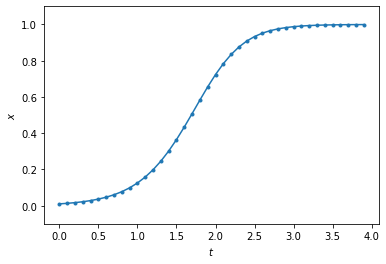

In [4]:
# Let's select a time-step
dt=0.1
# and set the time points and values of the variable
t = np.arange(tspan[0], tspan[-1], step=dt)
x = np.zeros(len(t))
# and set the initial value of the variable
x[0] = x0
# and then iterate over time to compute the updated variable value
for n in range(1,len(t)):
    x[n] = x[n-1] + dt*f(x[n-1])
# Let's plot the evolution over time,
plt.plot(t, x, ".-")
# and make it a legible plot
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.ylim([-0.1,1.1])
plt.show()

### Backward Euler
For the implicit Euler method, we need to rearrange our problem. Recall:
    $$ x' \approx (x_{n+1} - x_n) / \delta t \approx f(x_{n+1}) = r x_{n+1}(1-x_{n+1}) $$
Note that $f(x_{n+1})$ can not be evaluated directly, as it relies on our unknown. So we need to solve this expression for $x_{n+1}$ as a function of $x_n$. Rearranging:
    $$ \delta t \, r \, x_{n+1}^2 + (1 - \delta t \, r) x_{n+1} - x_n = 0$$
Which is a quadratic equation; plugging into the quadratic formula (remember that one?):
    $$ x_{n+1} = \frac{-1/\delta t + r \pm \sqrt{(1/\delta t - r)^2 + 4 r x_n/\delta t}}{2 r} $$
which gives us an update equation for $x_{n+1}$ as a function of $x_{n}$. 
There are two main issues with this. The first is that the quadratic formula gives us two solutions, and we need to use outside information or additional reasoning to determine which is relevant for our ODE model solution. The second is that no where do we have $f$ appearing in our update equation -- the information contained in $f$ is smeared throughout this formula -- so if we want to update our $f$, then we need to re-solve this problem and generate a new update equation. For more complicated ODE models, this is not always tractable or possible to do, analytically. 

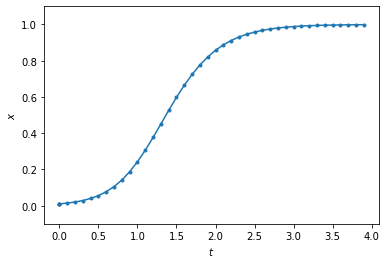

In [5]:
t = np.arange(tspan[0], tspan[-1], step=dt)
y = np.zeros(len(t))
y[0] = x0
plt.plot(t[0],y[0],".k")
for n in range(1,len(t)):
    y[n] = (-1/dt + r + np.sqrt((1/dt - r)**2 + 4*r*y[n-1]/dt))/(2*r)
plt.plot(t, y, ".-")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.ylim([-0.1,1.1])
plt.show()

### Accuracy and effort trade-offs
Look closely at the plots generated by the forward and backward Euler methods. Notice anything? 

**They do not agree!** If we look at the plot below, where we have plotted the Explicit and Implicit solved solutions for the same equation, with the same initial conditions, and the same time-step, we get very different answers. 

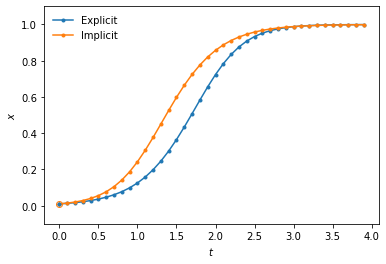

In [6]:
plt.plot(t, x, ".-C0", label="Explicit")
plt.plot(t, y, ".-C1", label="Implicit")
plt.plot(t[0], x[0], ".C0")
plt.plot(t[0], y[0], "oC1", markerfacecolor="none")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.ylim([-0.1,1.1])
plt.legend(loc=0, edgecolor="none")
plt.show()

### What is the error?
In fact, the difference between these two solutions scales like $O(\delta t^1)$.
You can (and should!) verify this by recomputing these two solutions for shrinking $\delta t$s, noting (visually) that they approach the same curve, and that their error shrinks in proportion to $\delta t^1$.

More important is if we choose to vary $r$ to approximate very fast changing dynamics. If we set `r=128.0`, then we will see, foremost, that the explicit method produces unreliable nonsense for large swathes of previously reasonable time steps $\delta t$ when `r=3.89`. The implicit method, however, works reliably despite our (relatively) large time step and (relatively) large `r=128.0`.
Intermediate values (e.g., `r=10.0`) produces an explicit solution where $x$ oscillates above and below $1$ -- this is both a hallmark of numerical instability and a mathematical impossibility for actual solutions of a one-dimensional ODE model; the corresponding implicit solution is not particular accurate, but it also correctly identifies the long-term trend $x(t\to\infty) \to 1$, which is useful information.

## Higher-Order systems
You may run into ODEs which are of higher order, for example second-order:
    $$ x '' = f(x) $$
which means the change in the change of $x$ varies as $f(x)$. Generically, we should expect to cast these into first order form:
    $$ x' = v, \quad v' = f(x) $$
So that now we have a two-dimensional system of equations to update every time-step.
This is a special case of the more general higher dimensional systems,
    $$ x' = f(x,y,\dots), y' = g(x,y,\dots), \dots,$$
Let's consider the simplest two-dimensional system,
    $$ x' = a_{11}x + a_{12}y, y' = a_{21}x + a_{22}y, $$
where we can write this system compactly as $\mathbf{x}' = A\mathbf{x}$, where $A$ is a $2\times 2$ matrix.

### Linear Stability

In this system, $\mathbf{x} = \mathbf{0}$ is always an equilibrium (the velocity vanishes for any $A$ at this point: $\mathbf{x}' = A\mathbf{0} = \mathbf{0}$) so it is the organizing feature of the system. We can characterize the dynamics around this point by considering the variation with respect to $\mathbf{x}$, by taking a derivative:
    $$ \mathrm{d}\mathbf{x}' / \mathrm{d}\mathbf{x} = A,$$
so the stability of $\mathbf{x} = \mathbf{0}$ is completely determined by the properties of $A$.

In practical terms, if points close to an equilibrium _diverge over time_ the equilibrium is said to be **unstable**. If points close to an equilibrium _converge over time_ then the equilibrium is said to be **stable**. There are some subtle implications to this characterization which may not be immediately obvious, but some experimentation will help us understand the simplest case.

Let's take a closer look, numerically.

Below, we will plot the dynamics of the system using a `streamplot`, and plot the equilibrium $\mathbf{x} = \mathbf{0}$ at the origin. The color of the equilibrium will be determined by its stability -- white for unstable, black for stable.

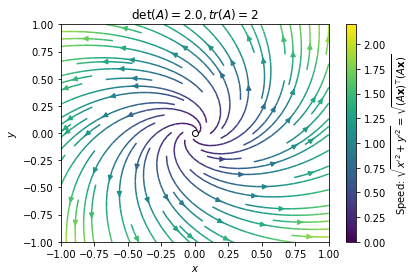

In [7]:
A = np.array([[1, -1],[1, 1]])
x = np.arange(-1.1,1.1,0.1)
y = np.arange(-1.1,1.1,0.1)
u = np.zeros((len(y),len(x)))
v = np.zeros((len(y),len(x)))
for n in range(len(y)):
    for m in range(len(x)):
        tmp = A@np.array([x[m],y[n]]) 
        # the matrix multiplication operator (@) in Python is different 
        # from the multiplication operator for other types (*)
        u[n,m] = tmp[0]
        v[n,m] = tmp[1]
plt.streamplot(x, y, u, v, color = np.sqrt(u**2 + v**2))
plt.colorbar(label=r"Speed: $\sqrt{x'^2 + y'^2} = \sqrt{(A \mathbf{x})^\top(A \mathbf{x})}$")
if np.max(np.linalg.eigvals(A)) < 0:
    plt.plot(0.,0., "ok")
else:
    plt.plot(0.,0.,"ok", markerfacecolor="w")
plt.title(r"$\det(A) = {0}, tr(A) = {1}$".format(np.round(np.linalg.det(A),decimals=3), np.round(np.trace(A),decimals=3)))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

The above figure is a visual tool to explore the stability properties of equilibria and build intuition -- please reference [this figure](https://en.wikipedia.org/wiki/Stability_theory#/media/File:Stability_Diagram.png) for a complete understanding about how the properties of $A$ affect the stability of the equilibrium $\mathbf{x}=\mathbf{0}$.

## Excitable dynamics

Let's take a look at an example of an _excitable_ two-dimensional system now.
$$ x' = x(1-x)(x-\beta) - y, \quad y' = \gamma (\alpha x - y), $$
This model is a formulation of the FitzHugh-Nagumo model, which is an archetypal model of slow-fast excitable systems.

In [8]:
# Let's encode this two-dimensional system in a function:
def F(X,P): # X = [x,y], P = [alpha, beta, gamma]
    return np.array([X[0]*(1.0-X[0])*(X[0]-P[1])-X[1], P[2]*(P[0]*X[0]-X[1])])

# and check that the system has the rest state like we expect for excitable systems
P = [0.3, 0.1, 0.05]
X0= np.array([0.0,0.0])
assert np.all(F(X0,P) == np.array([0.0,0.0])) # if you see nothing output, then it's true!

This rest state means that the dynamics of the system vanish at this point. This is an _equilibrium_ of the ODE system. We can also consider the curves defined by $x' = 0$ and $y'= 0$, that is, where the dynamics of each variable vanishes -- these are the _nullclines_ of the system, and they are very useful to gain an intuition for the orientation of the dynamics in a low-dimensional setting. The equilibrium is the intersection of the nullclines.

Below, we sample the function `F(X,P)` according to a grid of `X=[x,y]` values, and use these samples to draw the nullclines, equilibria, and representative dynamics of the model.
Try changing the values of the parameters in the array `P` to influence the shape of the nullclines and the representative dynamics. For some values of the parameters $\alpha$, $\beta$, and $\gamma$, the number of equilibria changes -- this is an example of a bifurcation, a small change in the parameters leads to a qualitative change in the dynamics of the model.

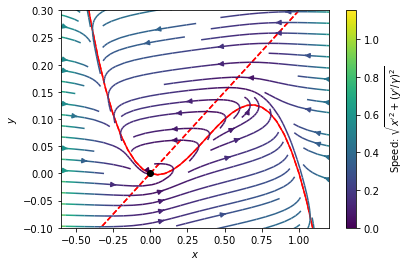

In [9]:
x = np.arange(-0.7, 1.3, step=0.05)
y = np.arange(-0.2, 0.4, step=0.05)
u = np.zeros((len(y),len(x)))
v = np.zeros((len(y),len(x)))
for (n,X) in enumerate(x):
    for (m,Y) in enumerate(y):
        tmp = F(np.array([X, Y]), P)
        u[m,n] = tmp[0]
        v[m,n] = tmp[1]
plt.contour(x, y, u, levels=[-1e-12, 1e-12], colors="red")
plt.contour(x, y, v, levels=[-1e-12, 1e-12], colors="red", linestyles="dashed")
plt.streamplot(x, y, u, v, color = np.sqrt(u**2 + (v/P[2])**2))
plt.plot(0, 0, "ok")
plt.colorbar(label=r"Speed: $\sqrt{x'^2 + (y'/\gamma)^2}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.xlim([-0.6,1.2])
plt.ylim([-0.1,0.3])
plt.show()

To solve this system, we need to specify the initial conditions and time interval, as well as make choices about our choice of solver. 
From now, we will use this model to make a point about time-steps and methods.
Let's use our explicit Euler method from earlier:

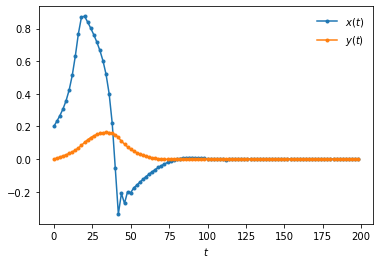

In [10]:
dt= 2.0
t = np.arange(0.0, 200.0, step=dt)
X = np.zeros((len(t), 2)) # 2 from the dimensionality of the ODE model
X0= np.array([0.2,0.0])
X[0,:] = X0
for n in range(1,len(t)):
    X[n, :] = X[n-1,:] + dt * F(X[n-1,:],P)
lineObjects = plt.plot(t, X, ".-")
plt.xlabel(r"$t$")
plt.legend(lineObjects, (r"$x(t)$", r"$y(t)$"), loc=0, edgecolor="none")
plt.show()

FitzHugh-Nagumo has a reputation for being extremely reliable for explicit methods, since the sole nonlinearity is cubic and thus a limiter on the maximal values of $x$. Even so, we can not choose time-steps large enough that we do not over-solve in the smooth regions _and_ do not get unphysical oscillations in the fast regions.
I need to emphasize that **this ODE model is very close to a best-case scenario for explicit methods**, and we are still stuck either wasting time oversolving or getting to an unreliable solution quickly.
The proper way to solve ODEs is to stand on the shoulders of giants, and use an ODE _solver_, like `solve_ivp`. 

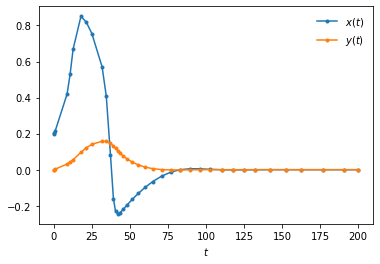

In [11]:
def fun(t,x): # this is the form your ODE must be written in to be used by solve_ivp!
    return F(x,P)
sol = solve_ivp(fun, (0.0, 200.0), X0)
lineObjects = plt.plot(sol.t, sol.y.transpose(), ".-")
plt.xlabel(r"$t$")
plt.legend(lineObjects, (r"$x(t)$", r"$y(t)$"), loc=0, edgecolor="none")
plt.show()

One especially nice feature of using `solve_ivp` is that we can specify that we want to be able to interpolate the solution to new time points -- decoupling the accuracy of our solution from the representation we would like for good looking plots. By passing the option `dense_output=True` to `solve_ivp`, our output `sol` now includes a function `sol.sol` which takes an array of time points to evaluate the solution on. There are [numerous other options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for `solve_ivp` that let us directly control the error of our solution (rather than indirectly by choosing `dt`), select different methods for the solution (important for stiff models, or solutions with high accuracy requirements), and several which are needed for speeding up the solution of large systems. Let's choose `dense_output=True` and `method='BDF'` as an example, and then interpolate the solution onto the time points we used for our Forward Euler method:

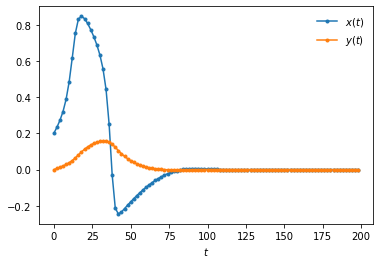

In [12]:
sol = solve_ivp(fun, (0.0, 200.0), X0, dense_output=True, method='BDF')
lineObjects = plt.plot(t, sol.sol(t).transpose(), ".-")
plt.xlabel(r"$t$")
plt.legend(lineObjects, (r"$x(t)$", r"$y(t)$"), loc=0, edgecolor="none")
plt.show()

We will take a closer look at FitzHugh-Nagumo in the workshop, but hopefully these numerical experiments give you a hint to the complexity and richness of numerical methods in the field.

## Conclusion

This concludes the introduction to solving ODEs in Python.
In this notebook, you've seen examples of scalar (one-dimensional) ODE models, which we solved using both Explicit and Implicit Euler methods. 
We then looked at a two-dimensional model and discussed linear stability.
Finally, we looked at an archetypal excitable model and solved it using Forward Euler and a built-in ODE solver. 
In the next section, we will look at coupling sets of ODEs into PDEs, and exploring how to solve these systems, and exploring some of the complications which arise.